# Imports and Setting up Plotting

In [7]:
from datetime import date, timedelta
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rcParams = {'figure.max_open_warning': 0,
            'figure.figsize': (15, 8),
            'axes.grid': True}

plt.rcParams.update(rcParams)
plt.style.use('bmh')

pd.options.display.max_rows = 50

# Loading Data

In [8]:
# Reading CSV files and Loading the data
filepath = r'C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\*.csv'
csv_files = glob.glob(filepath)

data = {}

for csv_file in csv_files:
    print('Loading ', csv_file)
    data_key = csv_file.rsplit('\\', 1)[-1].split('.')[0]    # Windows
    df = pd.read_csv(csv_file)
    df.set_index('dates', inplace=True)
    df.index = pd.to_datetime(df.index)
    data[data_key] = df

asset_prices = data['asset_prices']

# Firstly grab the data by country
countries = ['US', 'CA']
data_labels = ['Unemployment', 'IndustrialProduction', 'GDP', 'HomeSales']

economic_data = {}

for country in countries:
    tmp_data = {}

    for label in data_labels:
        tmp_data[f'{label}'] = data[f'{country}_{label}']

    economic_data[f'{country}'] = tmp_data

Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\asset_prices.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\CA_GDP.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\CA_HomeSales.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\CA_IndustrialProduction.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\CA_Unemployment.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\US_GDP.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\US_HomeSales.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\US_IndustrialProduction.csv
Loading  C:\Users\User\Desktop\OTPP\InvestmentAnalyticsFiles\US_Unemployment.csv


## Examining Data

In [9]:
asset_prices

,ES1 Index,PT1 Index,CADUSD Curncy,DXY Curncy
dates,,,,
1980-01-01,NaN,NaN,0.8559,85.820
1980-01-02,NaN,NaN,0.8578,85.320
1980-01-03,NaN,NaN,0.8545,85.260
1980-01-04,NaN,NaN,0.8557,85.230
1980-01-07,NaN,NaN,0.8551,84.790
...,...,...,...,...
2023-01-20,3988.50,1237.2,0.7474,102.012
2023-01-23,4036.50,1244.9,0.7481,102.138
2023-01-24,4032.75,1244.1,0.7480,101.918


In [10]:
economic_data

{'US': {'Unemployment':             actual_value  expected_value  number_of_forecaster
  dates                                                         
  1997-02-07           5.4             5.3                   0.0
  1997-03-07           5.3             5.3                   0.0
  1997-04-04           5.2             5.2                   0.0
  1997-05-02           4.9             5.2                   0.0
  1997-06-06           4.8             5.0                   0.0
  ...                  ...             ...                   ...
  2022-05-06           3.6             3.5                  76.0
  2022-06-03           3.6             3.5                  69.0
  2022-07-08           3.6             3.6                  74.0
  2022-08-05           3.5             3.6                  71.0
  2022-09-02           3.7             3.5                  71.0
  
  [307 rows x 3 columns],
  'IndustrialProduction':             actual_value  expected_value  number_of_forecaster
  dates        

# Building An Indicator

In this example, we assume that the growth rate of GDP is a good indication of the growth of a country's economy. For illustrative and simplicity reasons, we will focus on only this data. With this assumption, again for simplicity, we propose our indicator as just the actual value of GDP growth rate.

In [11]:
us_gdp = economic_data['US']['GDP']['actual_value']  # US GDP growth rate
ca_gdp = economic_data['CA']['GDP']['actual_value']  # Canada GDP growth rate

gdp = pd.concat([us_gdp, ca_gdp], axis=1, sort=True, keys=['US', 'CA'])


In [12]:
# our economic indicator is just the GDP growth rate
ca_indicator = ca_gdp
us_indicator = us_gdp

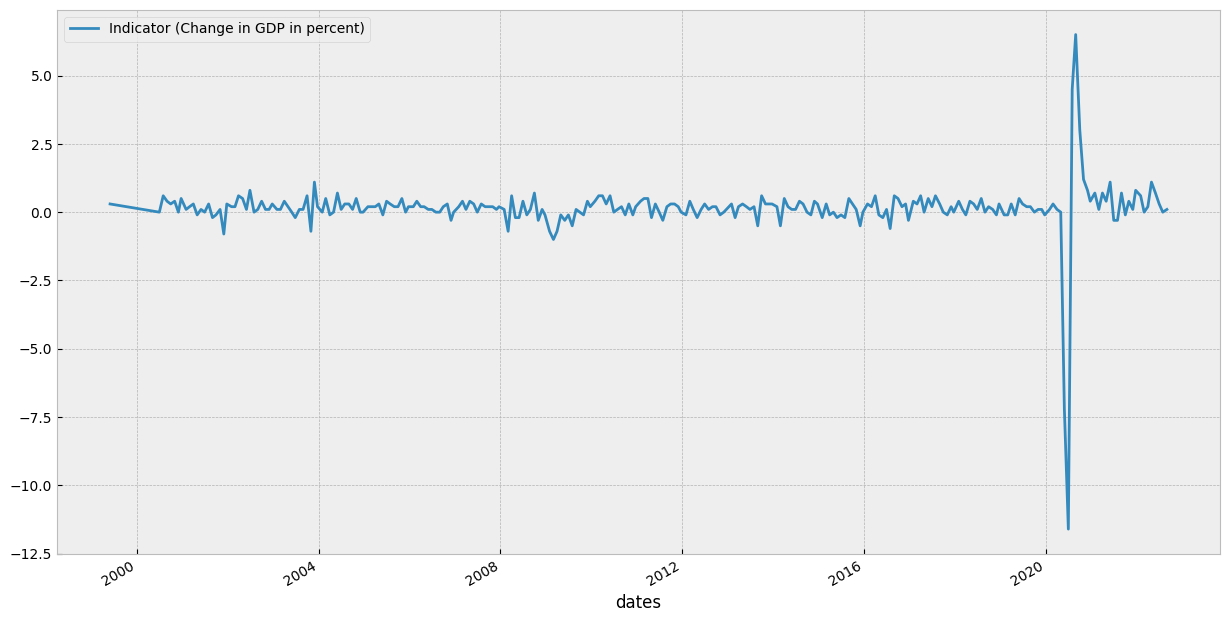

In [13]:
ca_indicator.plot(label='Indicator (Change in GDP in percent)')
plt.legend()

# Building a Trading Signal Using the Indicator

Using the indicator that we have created, we then try to create a trading signal.

We start by thinking how we can trade this strategy.

The most simplistic use of the indicator to trade would be using the indicator as the trading signal without any transformation. In our example, that would mean buy (go long) when the change in GDP is positive, and sell (go short) when the change in GDP is negative. This approach is shown in basic_signal() below.

We encourage you to try some new signals. As an example of how a signal might look like, you can look at the momentum trading signal in the Software Engineering project (Project 1).

In [14]:
def basic_signal(ts):
    # ts is a vector
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)), index=ts.index, columns=['signal'])
    signal[ts > 0] = 1
    signal[ts < 0] = -1
    
    return signal

In [15]:
ca_sgnl = basic_signal(ca_gdp)
us_sgnl = basic_signal(us_gdp)

## Show Performance of the Trading Signal

### Choose the assets you want to trade

In [16]:
# In this case, we are postulating that when the change in GDP is positive,
# both the country's stock market and the country's currency will rise.
ca_assets = ['PT1 Index', 'CADUSD Curncy']
us_assets = ['ES1 Index', 'DXY Curncy']

### Calculate PnL

In [17]:
def calculate_pnl(ret, pos):
    # function to calculate profit and loss
    # we trade at the end of the period, and take profit & loss on the market move next period on our position
    # that's why we are shifting positon vector by one
    return ret.multiply(pos.shift(), axis=0).dropna()

In [18]:
# build the return series for each of the series
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()

# Resample the Signal into daily signal
ca_daily_pos = ca_sgnl.resample('D').ffill()
us_daily_pos = us_sgnl.resample('D').ffill()

In [19]:
us_pnl = calculate_pnl(us_returns, us_daily_pos['signal'])
ca_pnl = calculate_pnl(ca_returns, us_daily_pos['signal'])

<AxesSubplot: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

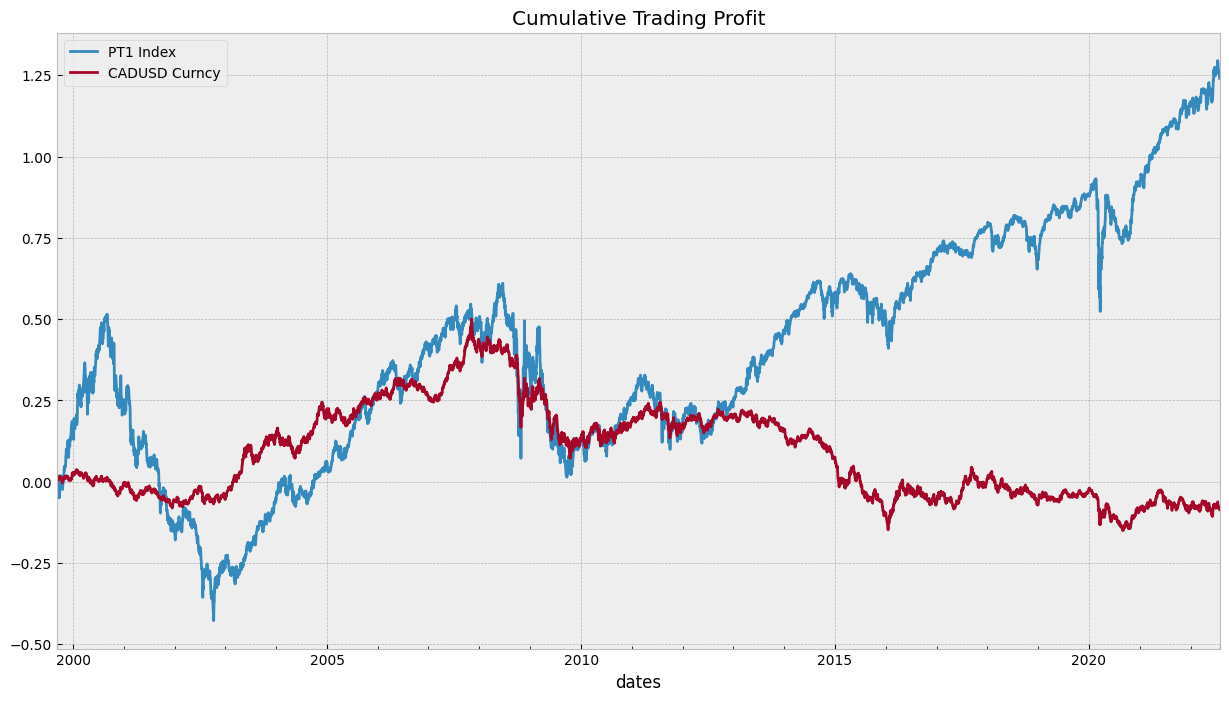

In [20]:
ca_pnl.cumsum().plot(title='Cumulative Trading Profit')

<AxesSubplot: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

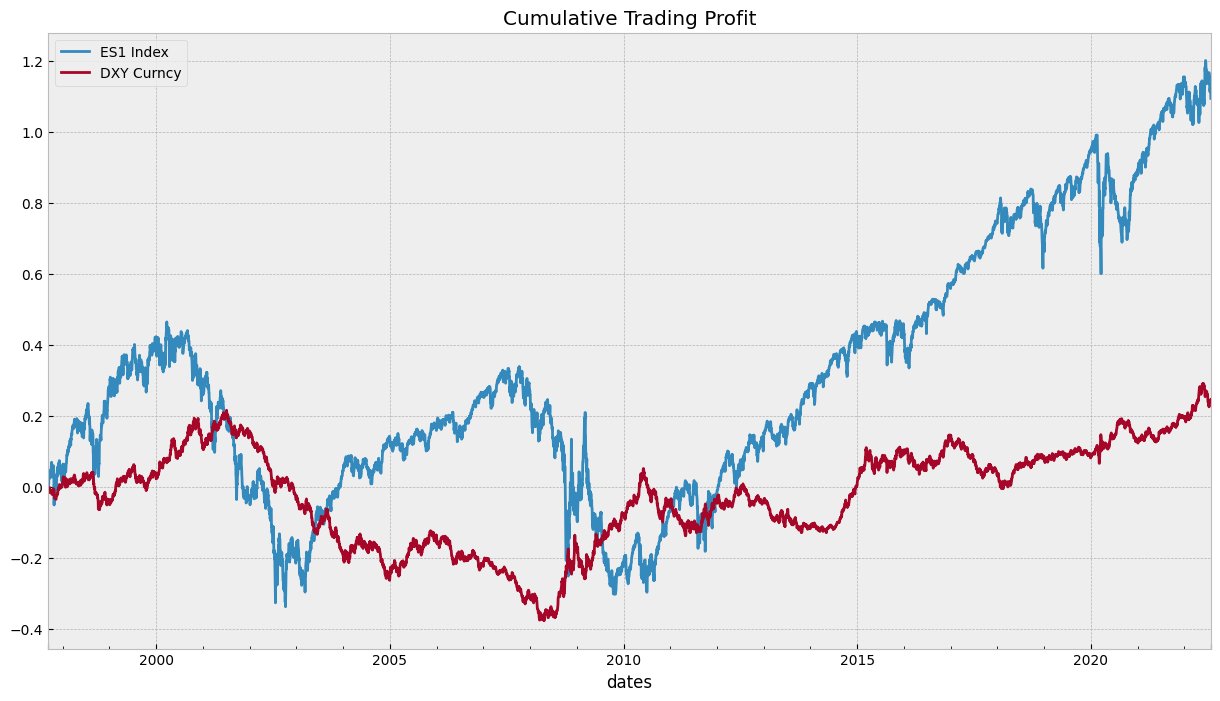

In [21]:
us_pnl.cumsum().plot(title='Cumulative Trading Profit')

## Some thoughts on the performance of the trading signal

Please examine the results of your trading signal and provide some commentary on the performance. 

If it performs well. Why? If it doesn't, why not? How can you make it better? 

What would be the next steps, if on the job, you are asked to further explore this investigation?

In [22]:
# Below is my contribution
# Consider the difference between actual and expected value
# Reasoning: market should have priced in the expected value. 
# Hence we only open a position when actual differs from expectation. 
# (Even better would be only when the difference exceeds certain threshold.)

economic_data_diff = dict()

for country_name in economic_data.keys():
    economic_data_diff[country_name] = dict()
    for data_name in economic_data[country_name].keys():
        economic_data_diff[country_name][data_name] = economic_data[country_name][data_name]['actual_value'] - economic_data[country_name][data_name]['expected_value']  # US GDP growth rate

# Example: we only 
gdp_diff = pd.concat([economic_data_diff["US"]["GDP"], economic_data_diff["CA"]["GDP"]], axis=1, sort=True, keys=['US', 'CA'])
gdp_diff.tail(15)

,US,CA
dates,,
2021-10-28,-0.6,NaN
2021-10-29,NaN,-0.3
2021-11-30,NaN,0.1
2021-12-23,NaN,0.0
2022-01-27,1.4,NaN
2022-02-01,NaN,0.2
2022-03-01,NaN,0.0
2022-03-31,NaN,0.0
2022-04-28,-2.4,NaN


In [23]:
signals_by_country_data = dict()
for country_name in economic_data_diff.keys():
    signals_by_country_data[country_name] = dict()
    for data_name in economic_data_diff[country_name].keys():
        signals_by_country_data[country_name][data_name] = basic_signal(economic_data_diff[country_name][data_name])


In [24]:
# Create combined signal by each country
country_name = "US"
signal_df_list = list()
for data_name, signal_df in signals_by_country_data[country_name].items():
    signal_df.columns = [data_name]
    signal_df_list.append(signal_df)

us_signal_by_data = pd.concat(signal_df_list, axis=1)

print("Merge all data into a single df")
print(us_signal_by_data.tail(5))

# Consider all signals by simply summing over each data type and tracking only the sign 
us_signal_by_data["signal"] = np.sign(us_signal_by_data.fillna(0).sum(axis=1))



Merge all data into a single df
            Unemployment  IndustrialProduction  GDP  HomeSales
dates                                                         
2022-07-28           NaN                   NaN -1.0        NaN
2022-08-05          -1.0                   NaN  NaN        NaN
2022-08-16           NaN                   1.0  NaN        NaN
2022-08-24           NaN                   NaN  NaN        1.0
2022-09-02           1.0                   NaN  NaN        NaN


<AxesSubplot: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

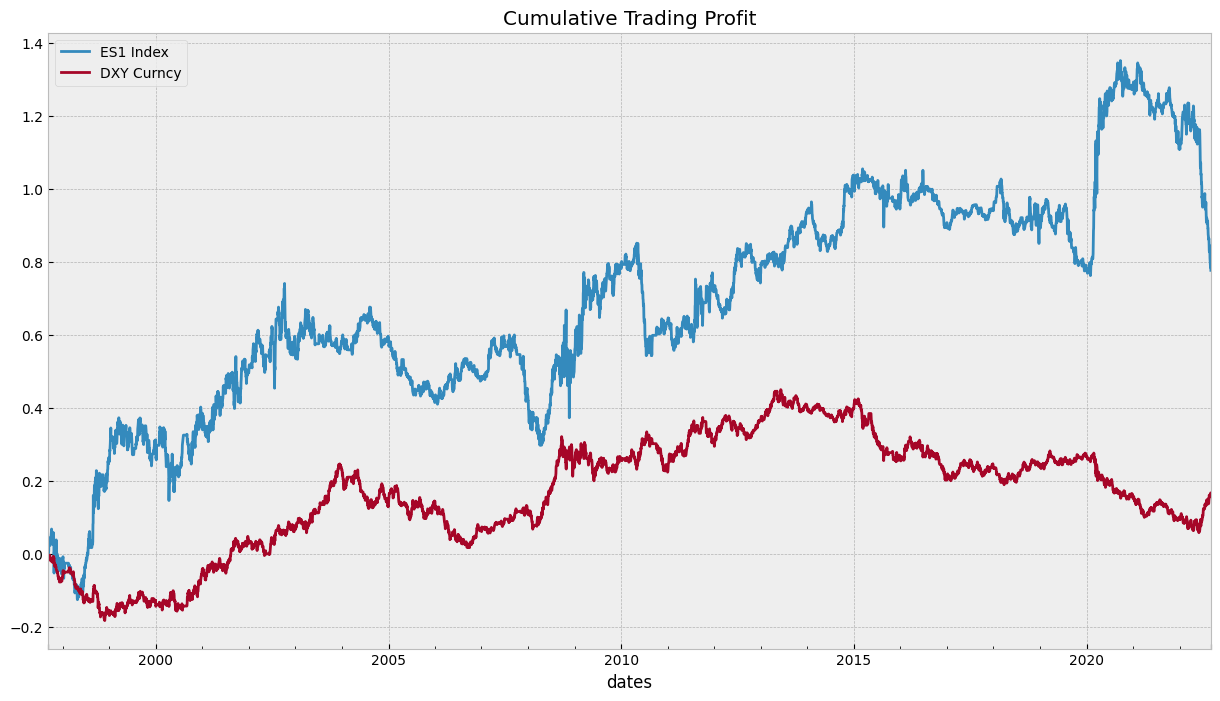

In [25]:
us_sgnl = us_signal_by_data[["signal"]]
us_daily_pos = us_sgnl.resample('D').ffill()

us_pnl = calculate_pnl(us_returns, us_daily_pos['signal'])
us_pnl.cumsum().plot(title='Cumulative Trading Profit')



In [26]:
# Performance

# ES1
# The signal appears to perform well for ES1 before 2022 and not so well after 2022
# That said, it did not show a massive drawdown during the Covid melt in 2020
# Each drawdown before 2022 is capped to be less than 30% which shows the resilliance of this signal. 
# This signal could be slightly biased as US stock market has been bullish since 2010s, so it may be more reasonable to compare the return against simple long ES1 strategy



# DXY
# The signal seems to be okay before 2015.
# Don't understand why it failed after 2015. Would like talk to an analyst/trader to understand the rationale.
# Compared to the returns from ES1, DXY is definitely less volatile (which is expected for an FX asset)






In [27]:
# Create combined signal by each country
country_name = "CA"
signal_df_list = list()
for data_name, signal_df in signals_by_country_data[country_name].items():
    signal_df.columns = [data_name]
    signal_df_list.append(signal_df)

ca_signal_by_data = pd.concat(signal_df_list, axis=1)

print("Merge all data into a single df")
print(ca_signal_by_data.tail(5))

# Consider all signals by simply summing over each data type and tracking only the sign 
ca_signal_by_data["signal"] = np.sign(ca_signal_by_data.fillna(0).sum(axis=1))



Merge all data into a single df
            Unemployment  IndustrialProduction  GDP  HomeSales
dates                                                         
2022-08-05          -1.0                   NaN  NaN        NaN
2022-08-15           NaN                  -1.0  NaN        NaN
2022-08-16           NaN                   NaN  NaN        1.0
2022-08-31           NaN                   NaN  0.0        NaN
2022-09-09           1.0                   NaN  NaN        NaN


<AxesSubplot: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

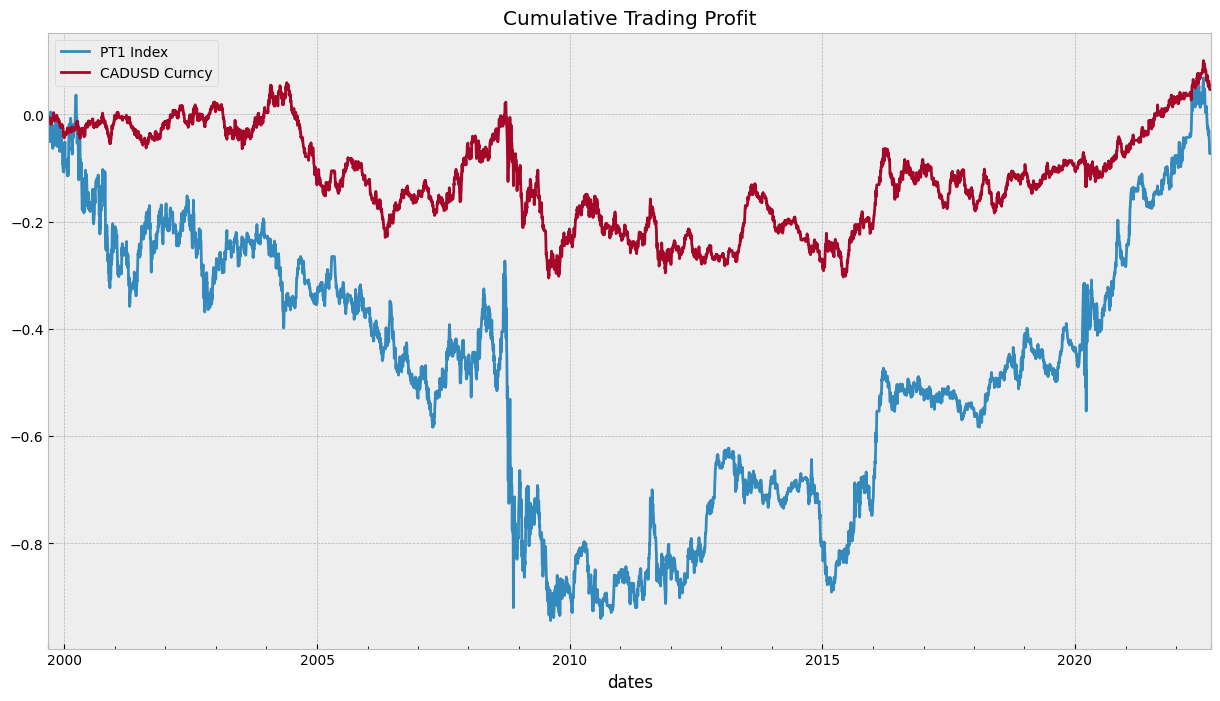

In [28]:
ca_sgnl = ca_signal_by_data[["signal"]]
ca_daily_pos = ca_sgnl.resample('D').ffill()

ca_pnl = calculate_pnl(ca_returns, ca_daily_pos['signal'])
ca_pnl.cumsum().plot(title='Cumulative Trading Profit')


In [29]:
# Performance

# PT1
# The signal completely failed with massive drawdown down to -90%
# This suggesting the methodology doesn't apply well to PT1 index.
# Would like to speak with analyst/trader to understand why too.


# CADUSD
# The performacne is not only driven by the performance of CA economy but its relative performance to USD
# To improve this, it is more sensible to include the US economy data in the signal generation



In [30]:
# On job
# Would drill into the performance of the signal by examining other metrics, e.g. drawdown, holding period, relative performance to simple long/short strategy, statistical significance of the signal, VaR consumption, etc